In [2]:
### Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants as c
import os, sys
from astropy.table import Table, vstack
from astropy import units as u
from astropy.io import ascii
from astropy.time import Time

### Get some information from the three vlbi surveys with b-smbh candidates

**GOODS-N** 
* central rms 9 uJy/beam
* \#sources targeted ~ 340 sources
* Contigious $7.5^2\cdot\pi$ arcmin squared. 
* Five separate pointings.
* One candidate bsmbh.

**COSMOS-VLBA**
* central rms ~10 uJy/beam
* \#sources targeted ~ 2865
* 4 deg squared area.
* Made of 23 pointings.
* 2 candidate bsmbhs

**SPARCS-N**
* central rms ~ 6 uJy/beam
* \# sources targeted ~ 52
* $0.5^2\cdot\pi$ area 
* One pointing
* One B-SMBH candidate

### SWEEPs estimates per year

In [3]:
if os.path.exists('evn_obs.ecsv') == False:
    import pyvo as vo
    service = vo.dal.TAPService("https://evn-vo.jive.eu/tap")
    x = np.linspace(-90,90,361)
    for i in range(360):
        if i%10 == 0:
            print(x[i])
        resultset = service.search("""SELECT *
                                    FROM evn.main WHERE s_dec BETWEEN %d AND %d"""%(x[i],x[i+1]))
        
        if i == 0:
            at = resultset.to_table()
        else:
            at = vstack([at, resultset.to_table()])
    at.write('evn_obs.ecsv', overwrite=True)
at = ascii.read('evn_obs.ecsv')

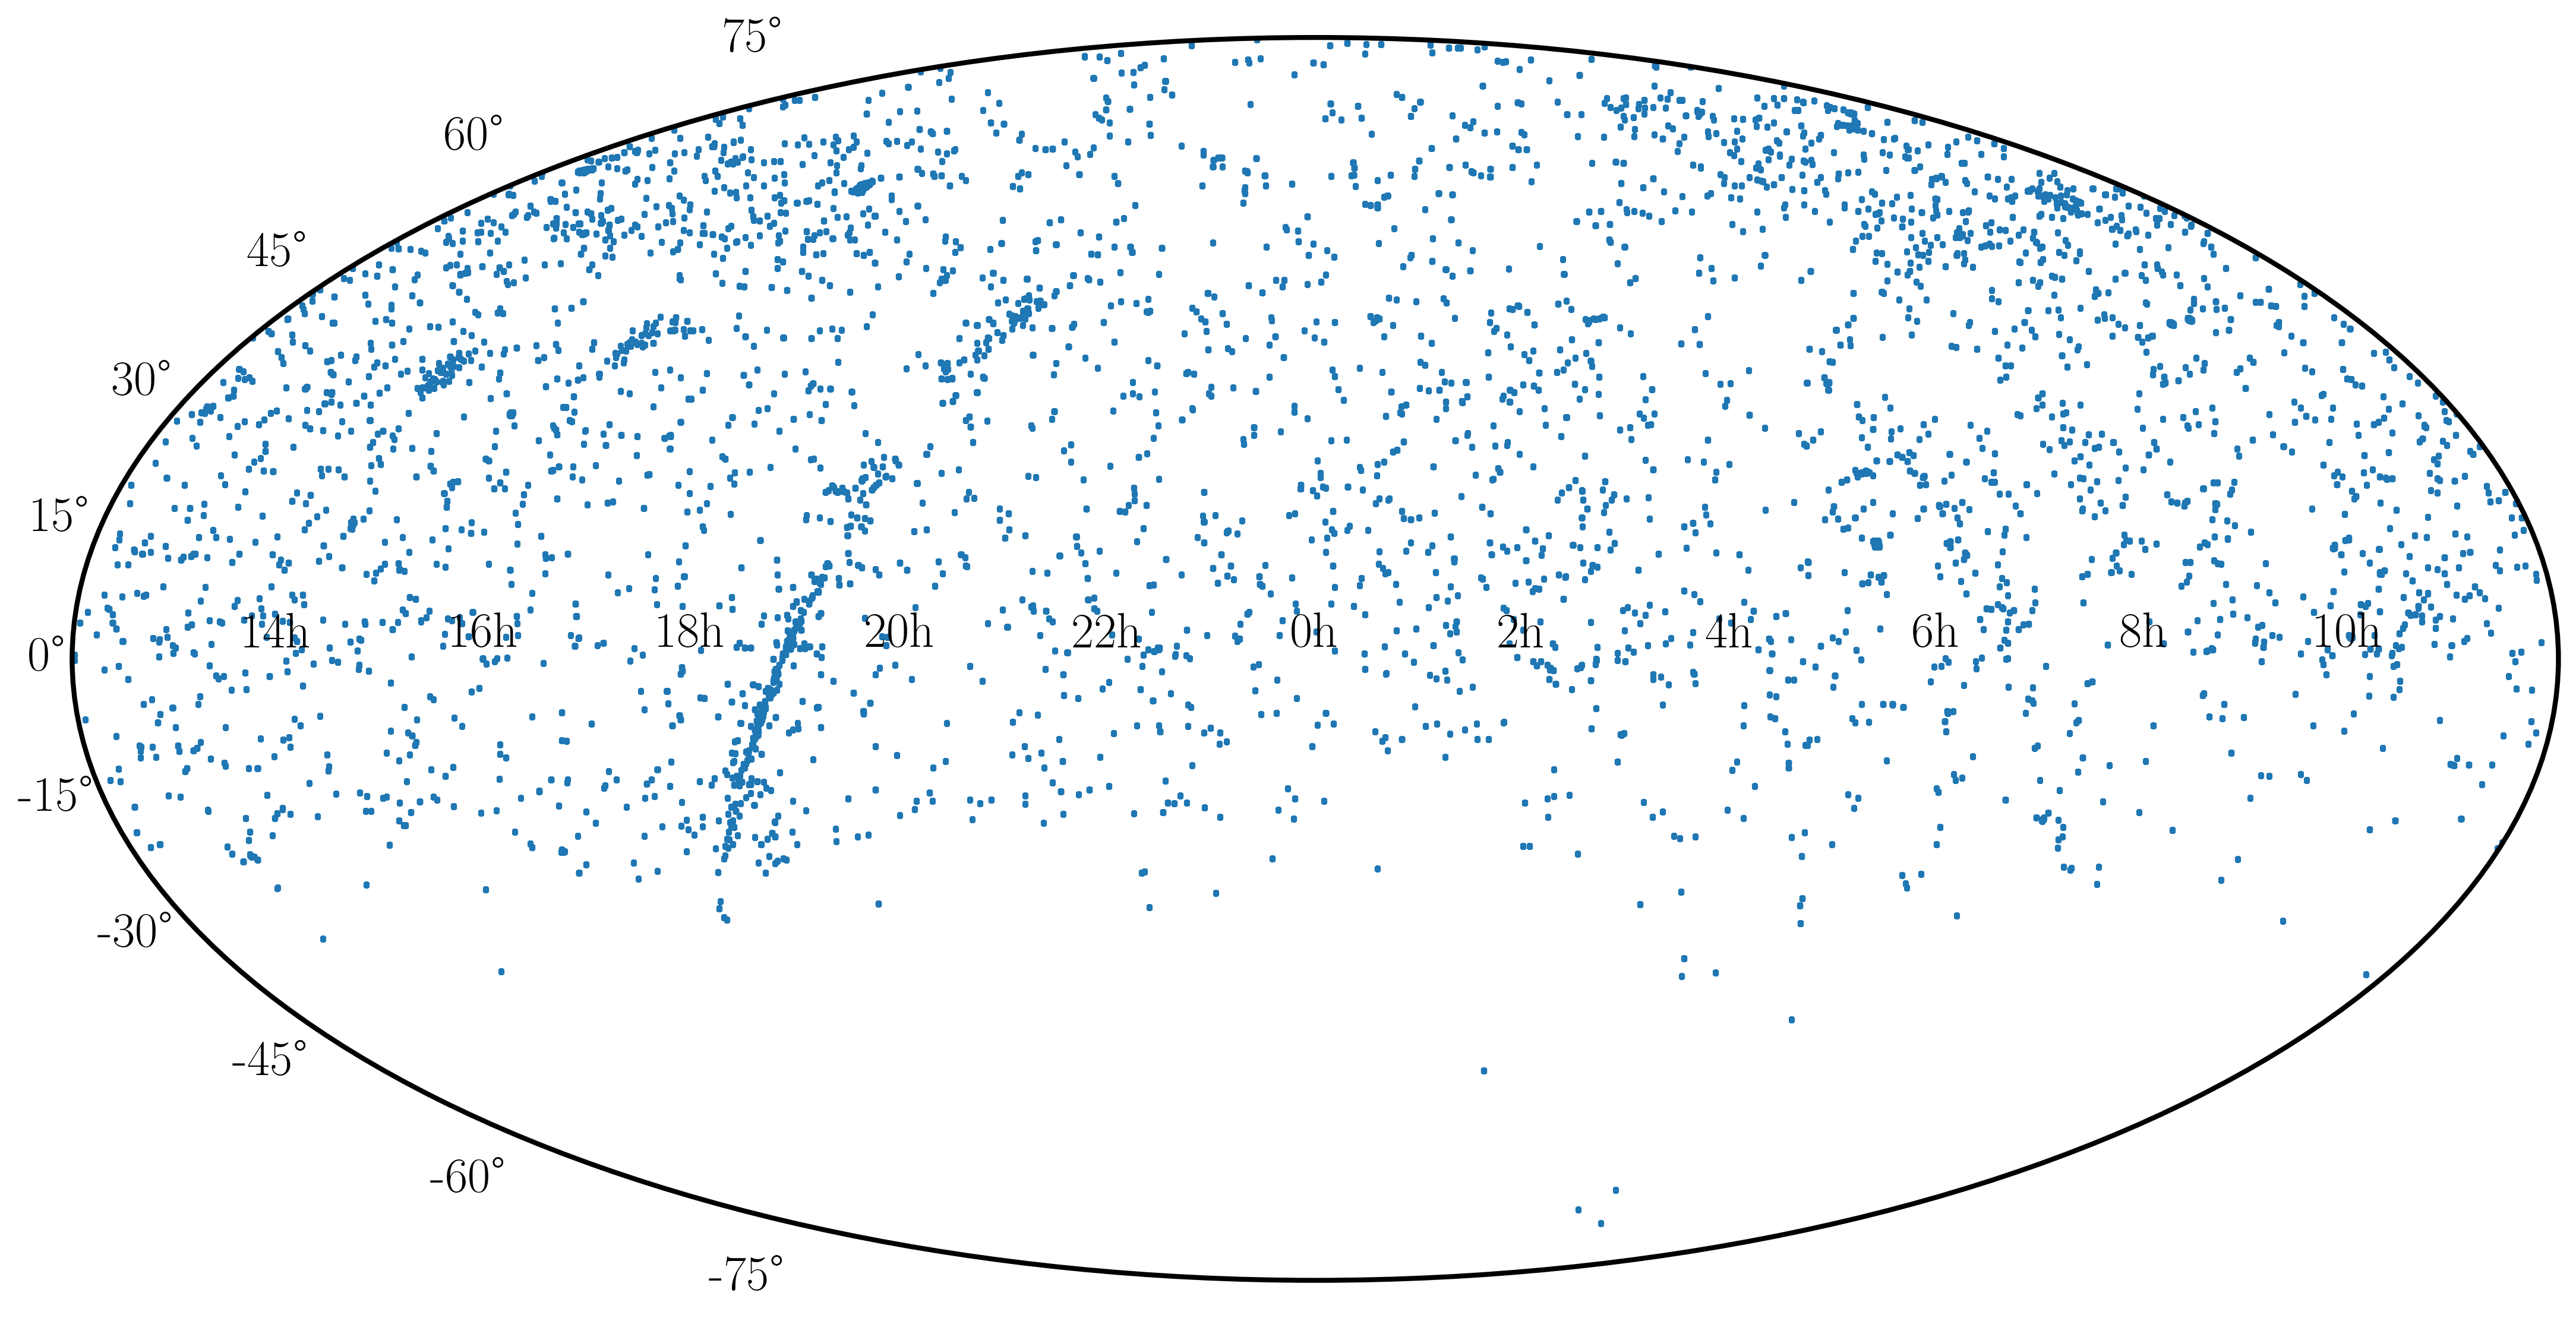

In [4]:
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter((at['s_ra']).to(u.radian), (at['s_dec']).to(u.radian),s=1.5)
#ax.scatter(ra, (evn_obs[1]*u.deg).to(u.radian),s=0.1)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
plt.show()

In [5]:
t = Time(at['t_max'],format='mjd')

In [6]:
t.min().isot,t.max().isot

('1998-11-23T00:35:13.250', '2024-06-06T14:59:59.500')

In [29]:
yr_iso = np.arange(1998,2026,2)
yr = Time(np.char.add(np.arange(1998,2026,2).astype('str'),'-01-01T00:00:00.000')).mjd

In [40]:
60*(at[0]['t_max'] - at[0]['t_min'])

22.083333329792367

In [43]:
at[0]['t_xel']

2673

In [48]:
n_exp = []
n_epo = []
L_exp = []
L_t = []
for i in range(len(yr)-1):
    n_epo.append(len(at['t_min'][(at['t_min']>yr[i])&(at['t_min']<yr[i+1])]))
    n_exp.append(len(np.unique(at['obs_id'][(at['t_min']>yr[i])&(at['t_min']<yr[i+1])])))
    L_exp.append(len(np.unique(at['obs_id'][(at['t_min']>yr[i])&(at['t_min']<yr[i+1])&\
                                           (at['em_min']>0.15)&(at['em_max']<0.25)])))
    t_min = np.unique(at['t_min'][(at['t_min']>yr[i])&(at['t_min']<yr[i+1])&\
                            (at['em_min']>0.15)&(at['em_max']<0.25)])
    t_max = np.unique(at['t_max'][(at['t_min']>yr[i])&(at['t_min']<yr[i+1])&\
                            (at['em_min']>0.15)&(at['em_max']<0.25)])
    L_t.append(np.sum(t_max-t_min))

ValueError: operands could not be broadcast together with shapes (64,) (62,) 

In [47]:
at[at['obs_id']=='ER047A']

accref,owner,embargo,mime,accsize,access_url,s_resolution_min,s_resolution_max,s_maximum_angular_scale,uv_distance_min,uv_distance_max,uv_distribution_ecc,uv_distribution_fill,s_region,s_dec,obs_publisher_did,em_max,em_min,em_res_power,em_xel,t_exptime,s_fov,obs_id,pol_xel,s_ra,access_estsize,s_resolution,target_name,t_max,t_min,t_resolution,t_xel
,,a,,byte,,arcsec,arcsec,arcsec,m,m,,,,deg,,m,m,,,s,deg,,,deg,kbyte,arcsec,,d,d,s,
object,object,object,object,int64,object,float32,float32,float32,float32,float32,float32,float32,object,float64,object,float64,float64,float64,int64,float32,float64,object,int64,float64,int64,float64,object,float64,float64,float32,int64
ER047A_190308_1_1_J1011%2B0106_1594.99MHz,,,application/x-votable+xml;content=datalink,15708957,http://evn-vo.jive.eu/evn/q/dl/dlmeta?ID=ivo%3A//jive.eu/~%3FER047A_190308_1_1_J1011%252B0106_1594.99MHz,0.0035344663,0.0041982103,186.45625,207.92702,10156996.0,0.41636428,0.046355344,Polygon ICRS 152.8151633425 0.9021456823 152.7742550301 0.9061740383 152.7349185158 0.9181043251 152.6986652306 0.9374781447 152.6668881882 0.9635510892 152.6408084788 0.9953213343 152.6214283597 1.0315681197 152.6094927414 1.0708986414 152.6054605464 1.1118015541 152.6094870423 1.1527050335 152.6214178292 1.1920371689 152.64079472 1.2282863697 152.6668732957 1.2600594637 152.6986514717 1.2861352573 152.7349079852 1.3055114921 152.774249331 1.3174433928 152.8151633425 1.3214723154 152.856077354 1.3174433928 152.8954186998 1.3055114921 152.9316752133 1.2861352573 152.9634533893 1.2600594637 152.989531965 1.2282863697 153.0089088558 1.1920371689 153.0208396427 1.1527050335 153.0248661386 1.1118015541 153.0208339436 1.0708986414 153.0088983253 1.0315681197 152.9895182062 0.9953213343 152.9634384968 0.9635510892 152.9316614544 0.9374781447 152.8954081692 0.9181043251 152.8560716549 0.9061740383,1.111808998888889,ivo://jive.eu/~?ER047A_190308_1_1_J1011%2B0106_1594.99MHz,0.1879588323437764,0.1740459787865241,3189.98,256,2406.0,0.0036593151944529,ER047A,4,152.8151633425,21313344,0.0032228901170168,J1011+0106,58551.18751736125,58550.70835069427,3.0,802
ER047A_190308_1_1_J1015%2B0109_1594.99MHz,,,application/x-votable+xml;content=datalink,15708957,http://evn-vo.jive.eu/evn/q/dl/dlmeta?ID=ivo%3A//jive.eu/~%3FER047A_190308_1_1_J1015%252B0109_1594.99MHz,0.018790692,0.023430392,100.4456,385.97302,1910496.9,0.4998917,0.008201394,Polygon ICRS 153.9877293075 0.9441552154 153.9468205097 0.9481835607 153.9074835164 0.960113817 153.8712297666 0.9794875909 153.8394522848 1.0055604816 153.8133721759 1.0373306728 153.7939917149 1.0735774126 153.7820558322 1.1129079038 153.7780234711 1.1538108058 153.7820499177 1.1947142958 153.7939807862 1.2340464618 153.8133578969 1.2702957082 153.8394368293 1.3020688561 153.8712154874 1.3281447035 153.9074725876 1.347520984 153.9468145951 1.3594529151 153.9877293075 1.3634818485 154.0286440199 1.3594529151 154.0679860274 1.347520984 154.1042431276 1.3281447035 154.1360217857 1.3020688561 154.1621007181 1.2702957082 154.1814778288 1.2340464618 154.1934086973 1.1947142958 154.1974351439 1.1538108058 154.1934027828 1.1129079038 154.1814669001 1.0735774126 154.1620864391 1.0373306728 154.1360063302 1.0055604816 154.1042288484 0.9794875909 154.0679750986 0.960113817 154.0286381053 0.9481835607,1.1538185319444445,ivo://jive.eu/~?ER047A_190308_1_1_J1015%2B0109_1594.99MHz,0.1879588323437764,0.1740459787865241,3189.98,256,360.0,0.0036593151944529,ER047A,4,153.98772930750002,21313344,0.0032228901170168,J1015+0109,58551.14342013886,58550.70835069427,3.0,120
ER047A_190308_365_1_ER047363_1594.99MHz,,,application/x-votable+xml;content=datalink,15708957,http://evn-vo.jive.eu/evn/q/dl/dlmeta?ID=ivo%3A//jive.eu/~%3FER047A_190308_365_1_ER047363_1594.99MHz,0.0035344006,0.004183546,179.22958,216.31079,10157185.0,0.40937144,0.08301639,Polygon ICRS 150.1089945833 2.3813944612 150.0680559119 2.3854224399 150.0286897729 2.3973516523 149.9924083694 2.4167238638 149.9606055506 2.4427949114 149.9345033112 2

In [46]:
L_t

[0.0,
 30.794803239426983,
 80.82797670945729,
 112.33827836550336,
 80.99222800746793,
 119.96657406989834,
 116.84078993194998,
 97.61671008328267,
 830.7648147303698,
 1562.1686520372605,
 1290.3572310840173,
 2300.0074245963115,
 184.11347221997858]

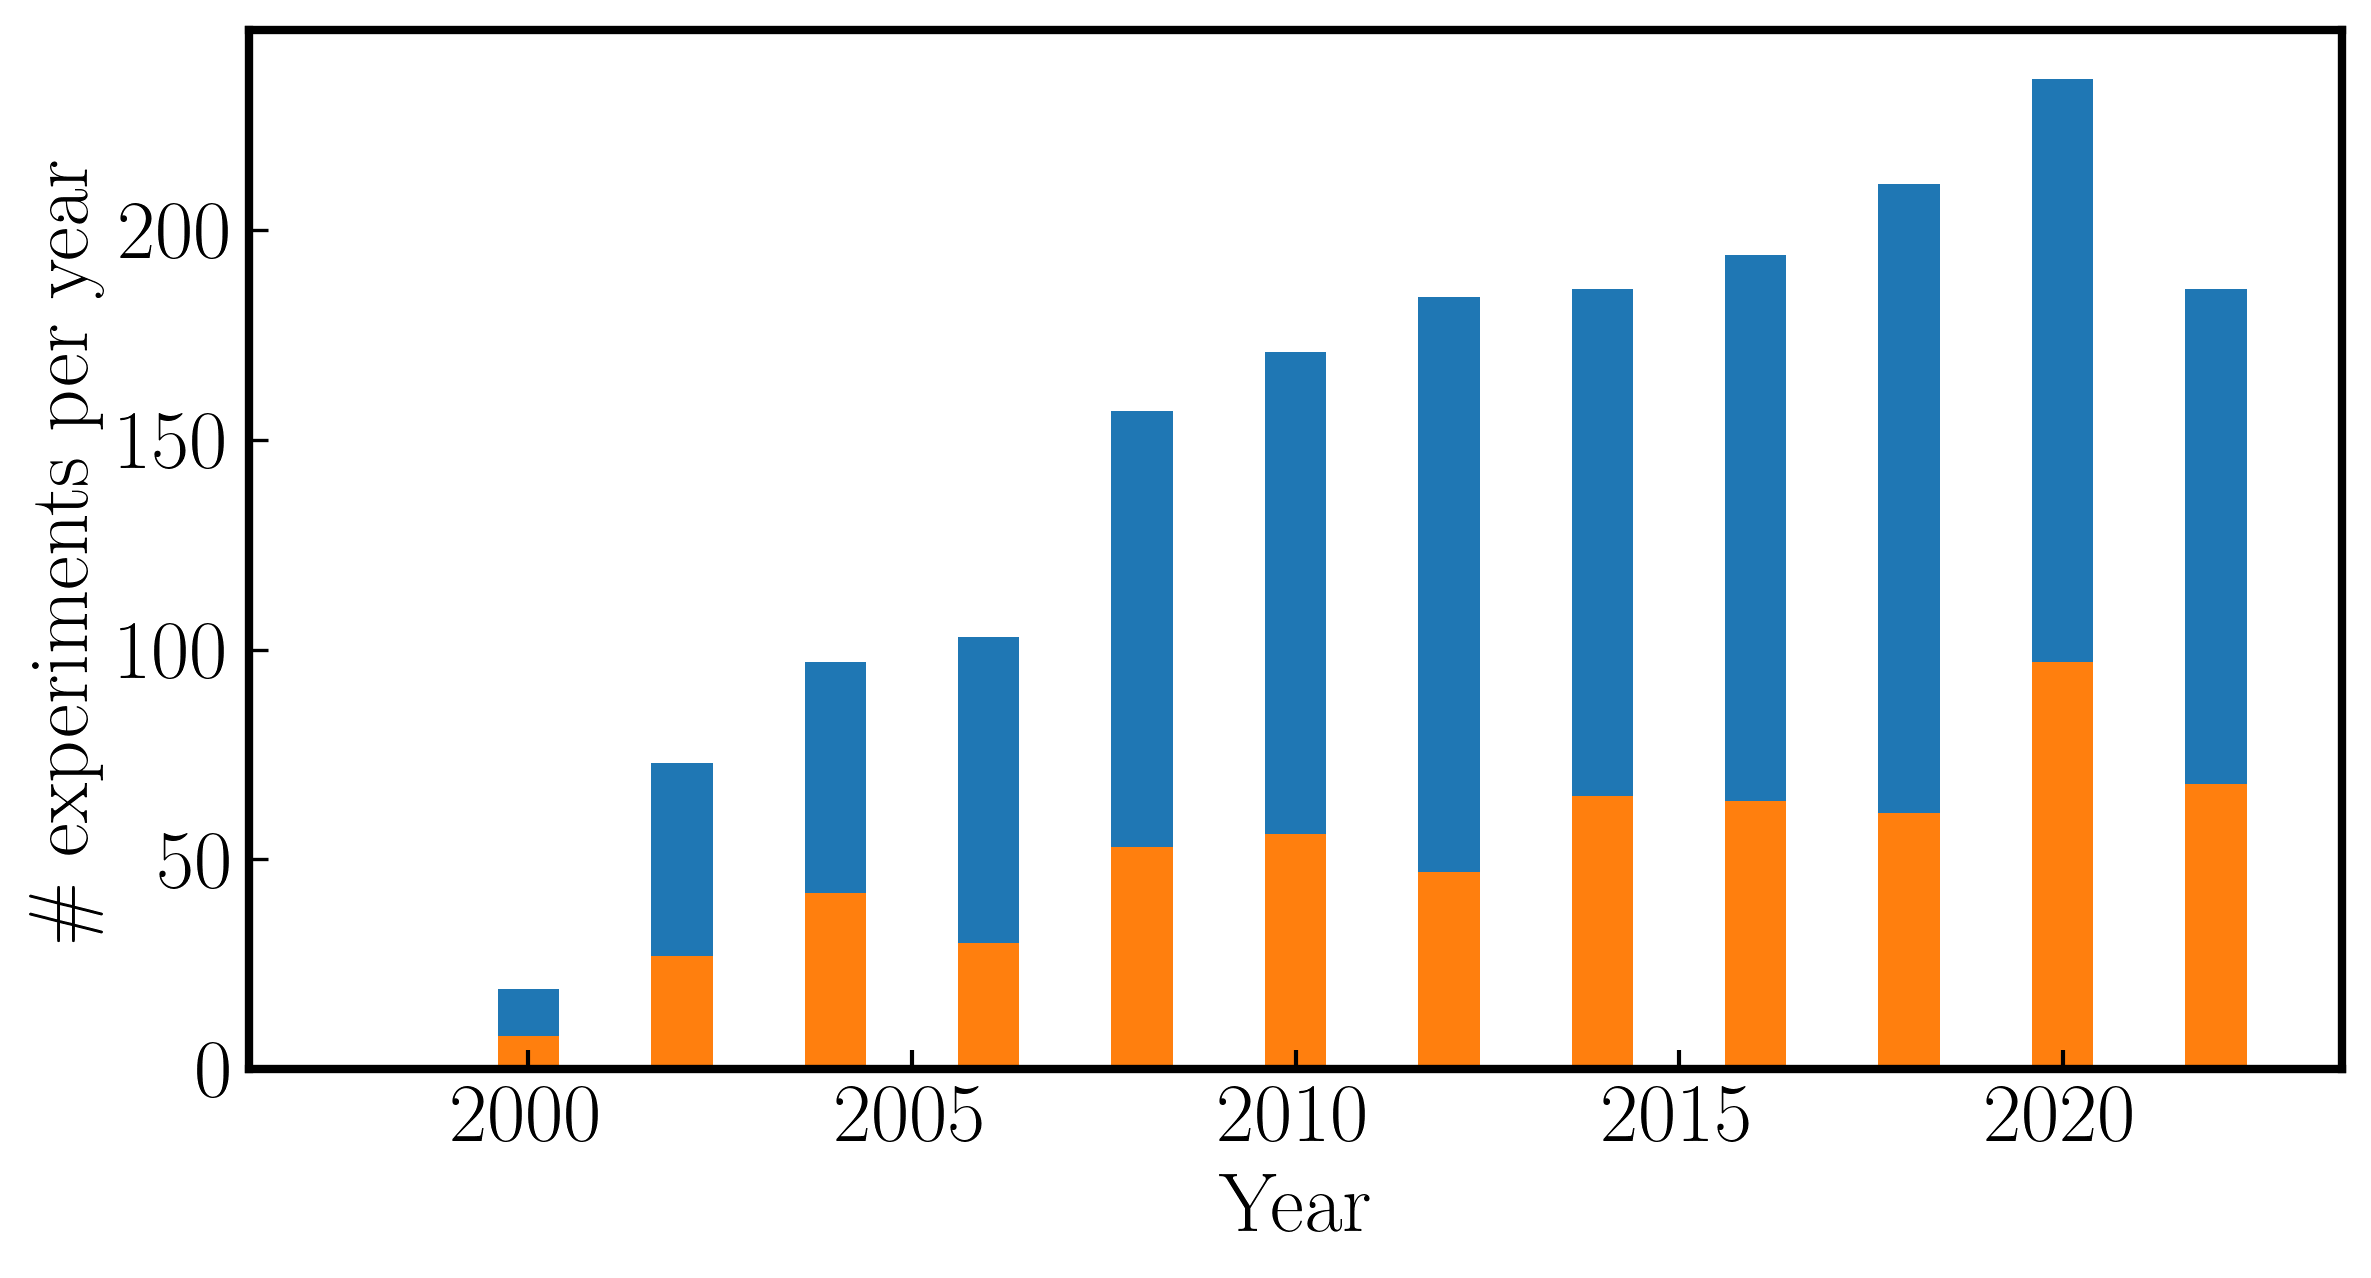

In [32]:
fig = plt.figure(figsize=(9,4.5))
ax = fig.add_subplot(111)
ax.bar(yr_iso[:-1],n_exp)
ax.bar(yr_iso[:-1],L_exp)
ax.set_xlabel('Year')
ax.set_ylabel('\# experiments per year')
plt.show()